In [1]:
import importlib
import sys
import torch
import pickle
import os
import pandas as pd

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

from aa_philipp.model_with_integrated_gradients.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

In [2]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)


In [3]:
#load model

file_path_model = '../../notebooks/training_variational_dropout/Helpdesk/Helpdesk_full_grad_norm_2layer.pkl'
model = DropoutUncertaintyEncoderDecoderLSTM.load(file_path_model, dropout=0.0)

# Load the dataset
file_path_data_set = '../../../encoded_data/test_weytjens//helpdesk_all_5_test.pkl'
helpdesk_test_dataset = torch.load(file_path_data_set, weights_only=False)

Data set categories:  ([('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('VariantIndex', 175, {'1.0': 1, '10.0': 2, '100.0': 3, '103.0': 4, '104.0': 5, '107.0': 6, '109.0': 7, '11.0': 8, '110.0': 9, '112.0': 10, '113.0': 11, '114.0': 12, '115.0': 13, '117.0': 14, '118.0': 15, '12.0': 16, '120.0': 17, '122.0': 18, '123.0': 19, '124.0': 20, '125.0': 21, '126.0': 22, '12

In [4]:

import evaluation.evaluation
importlib.reload(evaluation.evaluation)
from evaluation.evaluation import Evaluation


new_eval = Evaluation(model=model, 
                                   dataset=helpdesk_test_dataset,
                                   concept_name='Activity',
                                   #growing_num_values = [],
                                   growing_num_values = ['case_elapsed_time'],
                                   all_cat=['Activity', 'Resource'],
                                   all_num=['case_elapsed_time', 'event_elapsed_time'])


cases = new_eval._get_cases_from_dataset()

case_items = list(new_eval.cases.items())




# Integrated Gradients

In [5]:
from captum.attr import IntegratedGradients

from typing import Callable, Optional, Tuple


def forward_for_ig(
    model,
    prefixes_embedded: torch.Tensor,
    prefix_tuple: Tuple,
    target_fn: Callable,
):

    # ---------- Encoder ----------
    outputs, (h, c), _ = model.encoder.first_layer(
        input=prefixes_embedded, hx=None, z=None
    )

    for layer in model.encoder.hidden_layers:
        outputs, (h, c), _ = layer(input=outputs, hx=(h, c), z=None)

    # ---------- Decoder ----------

    # Get SOS event: Last prefix event:
    cat_prefixes, num_prefixes = prefix_tuple
    cat_sos_events = [cat_tens[:, -1:] for cat_tens in cat_prefixes]
    num_sos_events = [num_tens[:, -1:] for num_tens in num_prefixes]
    sos_event = [cat_sos_events, num_sos_events]


    print("prefix decoding after starting point: ", prefix_tuple)

    print("prefix decoding sos event only: ", sos_event)



    event = prefixes_embedded[-1, :, :].unsqueeze(0)
    event = model.decoder.data_enc_for_model(data=sos_event, pred=False) 

    print("prefix decoding after decoder.data_enc_for_model: ", event)

    outputs, (h, c), z_first = model.decoder.first_layer(
        input=event, hx=(h, c), z=None
    )
    
    for lstm_cell in model.decoder.hidden_layers:
        outputs, (h, c), z_h = lstm_cell(
            input=outputs, hx=(h, c), z=None
        )

    final_output = outputs[-1]

    # ---------- Post-Processing ----------

    cat_output_sizes, num_output_sizes = model.decoder.output_sizes

    prediction_means = [{}, {}]
    prediction_vars = [{}, {}]
    
    for key in cat_output_sizes:
        prediction_means[0][f"{key}_mean"] = model.decoder.output_layers[f"{key}_mean"](final_output)
        prediction_vars[0][f"{key}_var"]  = model.decoder.output_layers[f"{key}_var"](final_output)

    for key in num_output_sizes:
        prediction_means[1][f"{key}_mean"] = model.decoder.output_layers[f"{key}_mean"](final_output)
        prediction_vars[1][f"{key}_var"]  = model.decoder.output_layers[f"{key}_var"](final_output)

    predictions = [prediction_means, prediction_vars]

    # ---------- Target ----------
    target = target_fn(predictions)
    
    return target

In [6]:
def compute_integrated_gradients(
    model,
    prefix,
    target_fn: Callable,
    baselines: Optional[torch.Tensor] = None,
    n_steps: int = 50,
):
    """
    Returns:
        attributions: Tensor same shape as encoder input
    """

    # Encode prefix as model input
    prefixes_embedded = model.encoder.data_enc_for_model(data=prefix)
    prefixes_embedded = prefixes_embedded.detach()
    prefixes_embedded.requires_grad_(True)

    print("prefix encoding starting point: ",prefix )
    print("prefix encoding after encoder.data_enc_for_model: ",prefixes_embedded)

    baselines = torch.tensor([0.0])

    ig = IntegratedGradients(
        
        lambda x: forward_for_ig(
            model=model,
            prefixes_embedded=x,
            prefix_tuple=prefix,
            target_fn=target_fn,
        )
    )

    attributions = ig.attribute(
        inputs=prefixes_embedded,
        baselines=baselines,
        n_steps=n_steps,
    )

    return attributions


In [7]:
def target_fn_case_elapsed_time_mean(preds):
    return preds[0][1]["case_elapsed_time_mean"][0][0].unsqueeze(0)

In [8]:
def target_fn_activity(preds):
    print(f"the target activity (the predicted one is) {preds[0][0]["Activity_mean"].argmax()}")
    return preds[0][0]["Activity_mean"][0].max().unsqueeze(0)

In [ ]:
from tqdm import tqdm

torch.set_printoptions(sci_mode=False)

results_rows = []
for i, (case_name, full_case) in enumerate(tqdm(case_items)):
    for j, (prefix_len, prefix, suffix) in enumerate(new_eval._iterate_case(full_case)):
        attributions_case_elapsed_time = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=target_fn_case_elapsed_time_mean,
            baselines=None,     # defaults to zero embedding
            n_steps=20
        )

        attributions_predicted_activity = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=lambda x: target_fn_activity(x), 
            baselines=None,    # defaults to zero embedding
            n_steps=20
        )

        row = {
            'case_name': case_name,
            'prefix_len':prefix_len,
            'attributions_case_elapsed_time': attributions_case_elapsed_time,
            "attributions_predicted_activity":attributions_predicted_activity,
        }

        results_rows.append(row)

results_df = pd.DataFrame(results_rows)

        
        # output_attributes x seq_steps (padded) x batch_size x input_attributes
        #  for step in range(prefix_len):
        # list with columns time_output_value, ..all categorical values, prefix length, prefix, suffix, prediction

  0%|          | 0/916 [00:00<?, ?it/s]

encoder after i donno but before embedding ([tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]]), tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0, 341]]), tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])], [tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,

In [ ]:
import pickle

results_df = pd.DataFrame(results_rows)


with open ("results_store_integrated_gradients_helpdesk_on_case_elapsed_time_and_attributions_predicted_activity.pkl", "wb") as f:
   pickle.dump(results_df,f)

In [ ]:
import pickle
import pandas as pd

with open ("results_store_integrated_gradients_helpdesk_on_case_elapsed_time_and_attributions_predicted_activity.pkl", "rb") as f:
    results_df = pickle.load(f)

results_df = pd.DataFrame(results_df)

In [ ]:
results_df.head()

,case_name,prefix_len,attributions_case_elapsed_time,attributions_predicted_activity
0,Case 1016,1,"[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ...","[[[tensor(-0.0000, grad_fn=<UnbindBackward0>),..."
1,Case 1016,2,"[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ...","[[[tensor(-0.0000, grad_fn=<UnbindBackward0>),..."
2,Case 1016,3,"[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ...","[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ..."
3,Case 102,1,"[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ...","[[[tensor(-0.0000, grad_fn=<UnbindBackward0>),..."
4,Case 102,2,"[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ...","[[[tensor(-0.0000, grad_fn=<UnbindBackward0>),..."


In [ ]:
results_df.loc[0,"attributions_predicted_activity"].max()



tensor(0.0000, grad_fn=<MaxBackward1>)

In [ ]:
import pickle

with open("results_store_helpdesk_results.pkl", "rb") as f:
    inference_results = pickle.load(f)

inference_results = pd.DataFrame(inference_results)

In [ ]:

len(results_df["attributions_predicted_activity"][0][-1][0])

131

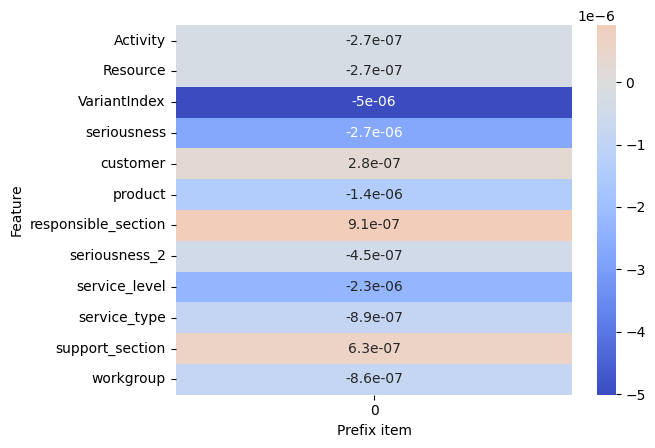

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 8   
                VariantIndex                         1.0   
                seriousness                      Value 1   
                customer                         Value 8   
                product                          Value 3   
                responsible_section              Value 1   
                seriousness_2                    Value 2   
                service_level                    Value 2   
                service_type                     Value 2   
                support_section                  Value 1   
                workgroup                        Value 2   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              27781.000314   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time     [699906.249423597]   
                event_elapsed_time   [366208.9382920583]   

                                               Timestep 2  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                VariantIndex                          NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [2224358.5507657807]   
                event_elapsed_time   [1150600.1999439963]   

                                               Timestep 3  
Prefix          Activity                              NaN  
                Resource                              NaN  
                VariantIndex                          NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time    [2224358.5507657807]  
                event_elapsed_time   [1079315.3239295376]

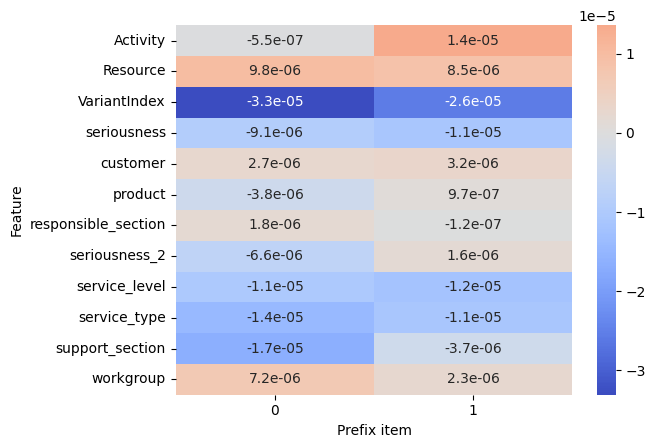

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 8   
                VariantIndex                         1.0   
                seriousness                      Value 1   
                customer                         Value 8   
                product                          Value 3   
                responsible_section              Value 1   
                seriousness_2                    Value 2   
                service_level                    Value 2   
                service_type                     Value 2   
                support_section                  Value 1   
                workgroup                        Value 2   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              27781.000314   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [1468898.994064969]   
                event_elapsed_time   [625537.7645886724]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 8  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                           Value 8  
                product                            Value 3  
                responsible_section                Value 1  
                seriousness_2                      Value 2  
                service_level                      Value 2  
                service_type                       Value 2  
                support_section                    Value 1  
                workgroup                          Value 2  
                case_elapsed_time               149.029932  
                event_elapsed_time              148.938768  
                day_in_week                            2.0  
                seconds_in_day                 27930.00031  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time       [3213337.27693169]  
                event_elapsed_time       [1855780.7243394]

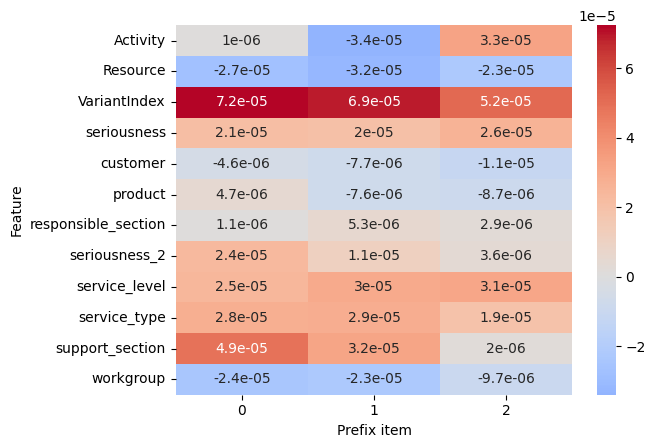

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                          Value 8   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 2   
                service_type                      Value 2   
                support_section                   Value 1   
                workgroup                         Value 2   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               27781.000314   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3435032.1257776767]   
                event_elapsed_time   [2032070.6655079303]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 8        Value 16  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                           Value 8         Value 8  
                product                            Value 3         Value 3  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 2         Value 2  
                service_level                      Value 2         Value 2  
                service_type                       Value 2         Value 2  
                support_section                    Value 1         Value 1  
                workgroup                          Value 2         Value 2  
                case_elapsed_time               149.029932    26071.995951  
                event_elapsed_time              148.938768     25922.95599  
                day_in_week                            2.0             2.0  
                seconds_in_day                 27930.00031    53853.000029  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

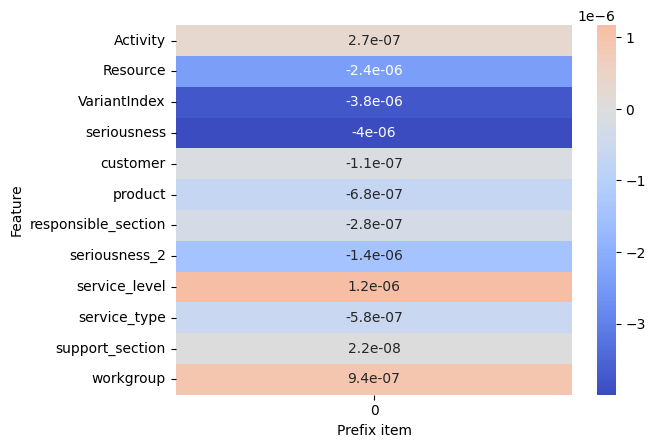

Timestep 1            Timestep 2
Prefix          Activity              Assign seriousness                   NaN
                Resource                         Value 4                   NaN
                VariantIndex                         1.0                   NaN
                seriousness                      Value 1                   NaN
                customer                        Value 62                   NaN
                product                          Value 3                   NaN
                responsible_section              Value 1                   NaN
                seriousness_2                    Value 4                   NaN
                service_level                    Value 1                   NaN
                service_type                     Value 1                   NaN
                support_section                  Value 1                   NaN
                workgroup                        Value 1                   NaN
                case_elapsed_time               0.070602                   NaN
                event_elapsed_time           963303.3125                   NaN
                day_in_week                         -0.0                   NaN
                seconds_in_day              32968.999659                   NaN
Mean Prediction Activity                  Resolve ticket                Closed
                Resource                         Value 2               Value 5
                case_elapsed_time    [777030.0347539268]   [2474231.335498253]
                event_elapsed_time   [367728.4623835896]  [1301448.4981970133]

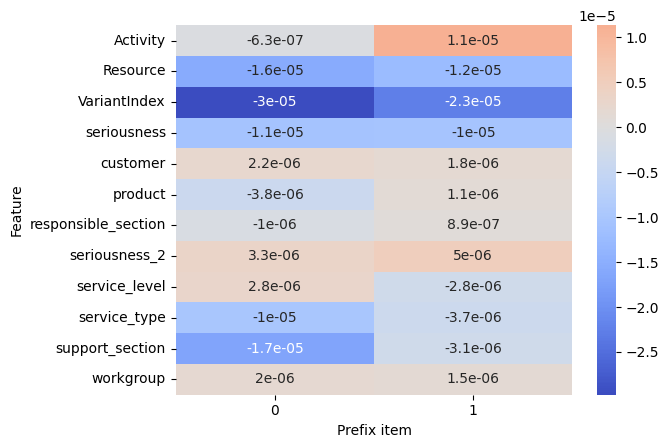

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 4   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 62   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 4   
                service_level                     Value 1   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day               32968.999659   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1584298.9267819193]   
                event_elapsed_time     [672506.501578377]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 4  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                          Value 62  
                product                            Value 3  
                responsible_section                Value 1  
                seriousness_2                      Value 4  
                service_level                      Value 1  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                28.000476  
                event_elapsed_time               27.995833  
                day_in_week                           -0.0  
                seconds_in_day                 32996.99974  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [3266100.4848477812]  
                event_elapsed_time    [1855818.1217740776]

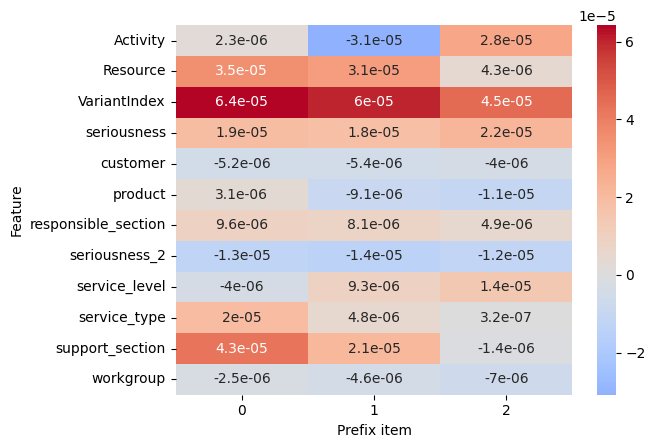

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 4   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 62   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 4   
                service_level                     Value 1   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day               32968.999659   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3446540.4590666313]   
                event_elapsed_time   [2040415.8201555554]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 4         Value 2  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                          Value 62        Value 62  
                product                            Value 3         Value 3  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 4         Value 4  
                service_level                      Value 1         Value 1  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time                28.000476    82957.065346  
                event_elapsed_time               27.995833    82928.989434  
                day_in_week                           -0.0             1.0  
                seconds_in_day                 32996.99974    29525.999706  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

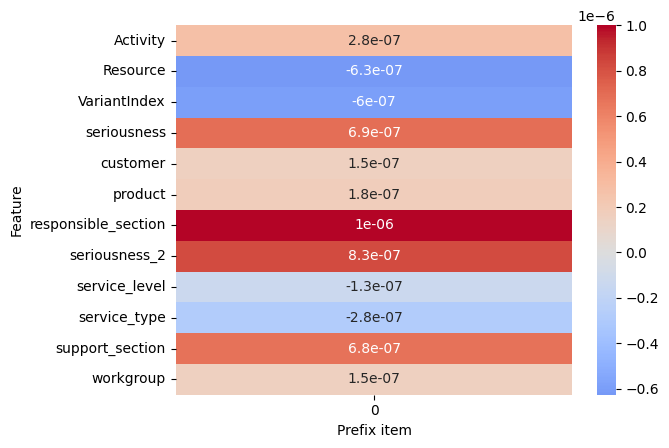

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 1   
                VariantIndex                           2.0   
                seriousness                        Value 1   
                customer                          Value 71   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 3   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            2.0   
                seconds_in_day                54445.000002   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [338326.76787914836]   
                event_elapsed_time    [283788.03195523843]   

                                                Timestep 2  \
Prefix          Activity                               NaN   
                Resource                               NaN   
                VariantIndex                           NaN   
                seriousness                            NaN   
                customer                               NaN   
                product                                NaN   
                responsible_section                    NaN   
                seriousness_2                          NaN   
                service_level                          NaN   
                service_type                           NaN   
                support_section                        NaN   
                workgroup                              NaN   
                case_elapsed_time                      NaN   
                event_elapsed_time                     NaN   
                day_in_week                            NaN   
                seconds_in_day                         NaN   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [494094.25046030176]   
                event_elapsed_time    [216201.37996599195]   

                                              Timestep 3            Timestep 4  
Prefix          Activity                             NaN                   NaN  
                Resource                             NaN                   NaN  
                VariantIndex                         NaN                   NaN  
                seriousness                          NaN                   NaN  
                customer                             NaN                   NaN  
                product                              NaN                   NaN  
                responsible_section                  NaN                   NaN  
                seriousness_2                        NaN                   NaN  
                service_level                        NaN                   NaN  
                service_type                         NaN                   NaN  
                support_section                      NaN                   NaN  
                workgroup                            NaN                   NaN  
                case_elapsed_time                    NaN                   NaN  
                event_elapsed_time                   NaN                   NaN  
                day_in_week                          NaN                   NaN  
                seconds_in_day                       NaN                   NaN  
Mean Prediction Activity                  Resolve ticket         

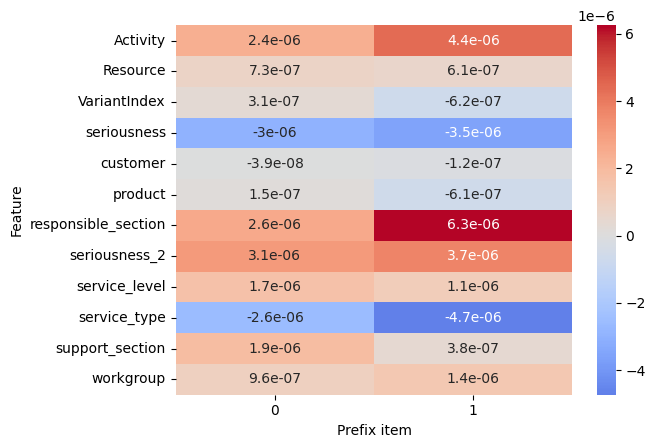

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 1   
                VariantIndex                         2.0   
                seriousness                      Value 1   
                customer                        Value 71   
                product                          Value 1   
                responsible_section              Value 1   
                seriousness_2                    Value 1   
                service_level                    Value 3   
                service_type                     Value 1   
                support_section                  Value 1   
                workgroup                        Value 1   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              54445.000002   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time     [777766.011446921]   
                event_elapsed_time   [332703.0475065778]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 1  
                VariantIndex                           2.0  
                seriousness                        Value 1  
                customer                          Value 71  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 3  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                 9.013061  
                event_elapsed_time                 9.02078  
                day_in_week                            2.0  
                seconds_in_day                54453.999593  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [2410379.4774074215]  
                event_elapsed_time    [1276023.8153865738]

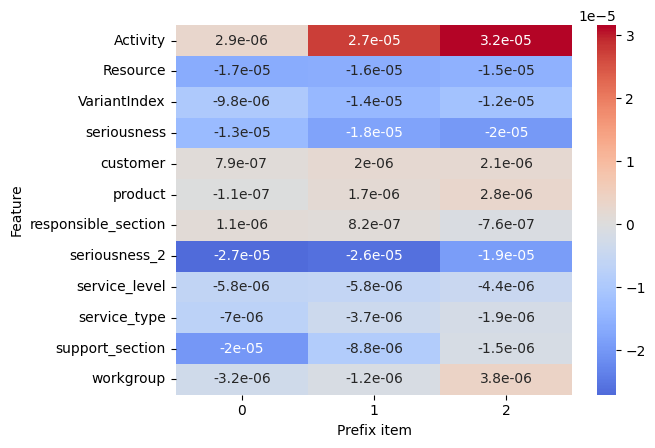

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                         Value 71   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               54445.000002   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1818347.4776183176]   
                event_elapsed_time    [864995.4386384833]   

                                                Timestep 2     Timestep 3  
Prefix          Activity             Take in charge ticket           Wait  
                Resource                           Value 1        Value 1  
                VariantIndex                           2.0            2.0  
                seriousness                        Value 1        Value 1  
                customer                          Value 71       Value 71  
                product                            Value 1        Value 1  
                responsible_section                Value 1        Value 1  
                seriousness_2                      Value 1        Value 1  
                service_level                      Value 3        Value 3  
                service_type                       Value 1        Value 1  
                support_section                    Value 1        Value 1  
                workgroup                          Value 1        Value 1  
                case_elapsed_time                 9.013061  508925.993816  
                event_elapsed_time                 9.02078  508916.996351  
                day_in_week                            2.0            1.0  
                seconds_in_day                54453.999593   44971.000006  
Mean Prediction Activity                            Closed            NaN  
                Resource                           Value 5            NaN  
                case_elapsed_time      [3252994.758736482]            NaN  
                event_elapsed_time     [1837712.605123189]            NaN

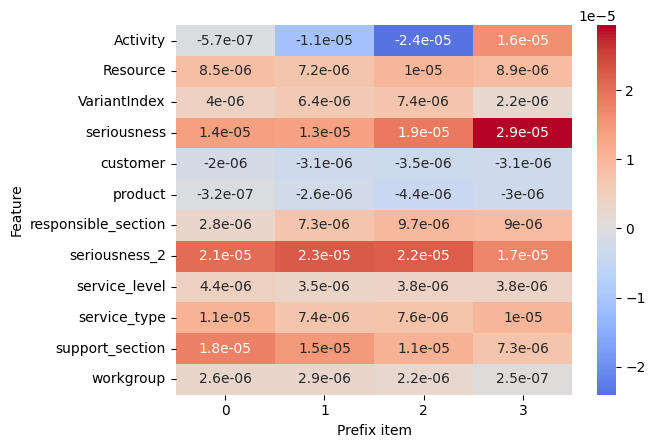

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                         Value 71   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               54445.000002   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time     [3461266.362897894]   
                event_elapsed_time   [1881439.6016761158]   

                                                Timestep 2     Timestep 3  \
Prefix          Activity             Take in charge ticket           Wait   
                Resource                           Value 1        Value 1   
                VariantIndex                           2.0            2.0   
                seriousness                        Value 1        Value 1   
                customer                          Value 71       Value 71   
                product                            Value 1        Value 1   
                responsible_section                Value 1        Value 1   
                seriousness_2                      Value 1        Value 1   
                service_level                      Value 3        Value 3   
                service_type                       Value 1        Value 1   
                support_section                    Value 1        Value 1   
                workgroup                          Value 1        Value 1   
                case_elapsed_time                 9.013061  508925.993816   
                event_elapsed_time                 9.02078  508916.996351   
                day_in_week                            2.0            1.0   
                seconds_in_day                54453.999593   44971.000006   
Mean Prediction Activity                               NaN            NaN   
                Resource                               NaN            NaN   
                case_elapsed_time                      NaN            NaN   
                event_elapsed_time                     NaN            NaN   

                                         Timestep 4  
Prefix          Activity             Resolve ticket  
                Resource                    Value 1  
                VariantIndex                    2.0  
                seriousness                 Value 1  
                customer                   Value 71  
                product                     Value 1  
                responsible_section         Value 1  
                seriousness_2               Value 1  
                service_level               Value 3  
                service_type                Value 1  
                support_section             Value 1  
                workgroup                   Value 1  
                case_elapsed_time    2928271.992832  
                event_elapsed_time   2419346.063923  
                day_in_week                     1.0  
                seconds_in_day         45116.999993  
Mean Prediction Activity                        NaN  
                Resource                        NaN  
                case_elapsed_time               NaN  
                event_elapsed_time              NaN

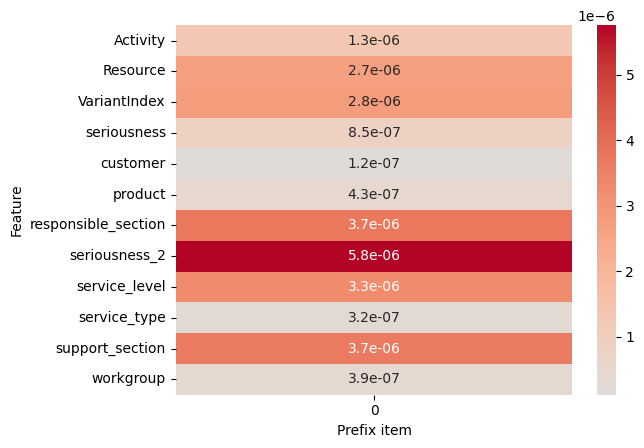

Timestep 1            Timestep 2
Prefix          Activity              Assign seriousness                   NaN
                Resource                         Value 1                   NaN
                VariantIndex                         1.0                   NaN
                seriousness                      Value 1                   NaN
                customer                        Value 17                   NaN
                product                          Value 1                   NaN
                responsible_section              Value 1                   NaN
                seriousness_2                    Value 1                   NaN
                service_level                    Value 2                   NaN
                service_type                     Value 1                   NaN
                support_section                  Value 1                   NaN
                workgroup                        Value 1                   NaN
                case_elapsed_time               0.070602                   NaN
                event_elapsed_time           963303.3125                   NaN
                day_in_week                          1.0                   NaN
                seconds_in_day              30143.000185                   NaN
Mean Prediction Activity                  Resolve ticket                Closed
                Resource                         Value 2               Value 5
                case_elapsed_time    [825521.2274907057]   [2599100.291917503]
                event_elapsed_time   [389197.9980292234]  [1401088.8046290567]

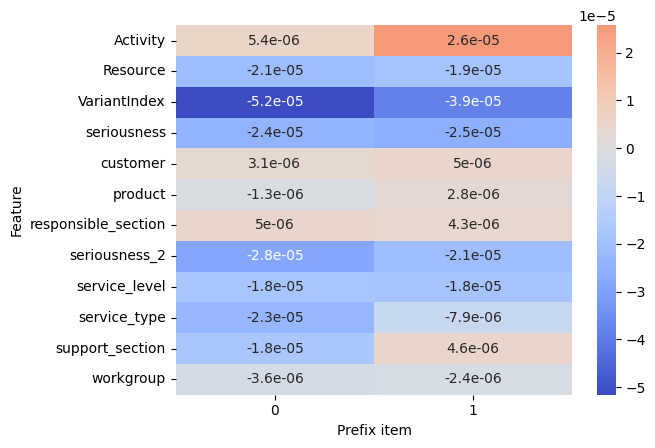

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               30143.000185   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1675662.2012541466]   
                event_elapsed_time    [725357.8734652749]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 4  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                          Value 17  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 2  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time               295.049276  
                event_elapsed_time              294.936142  
                day_in_week                            1.0  
                seconds_in_day                30437.999734  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [3273826.0351341288]  
                event_elapsed_time    [1852265.5497035065]

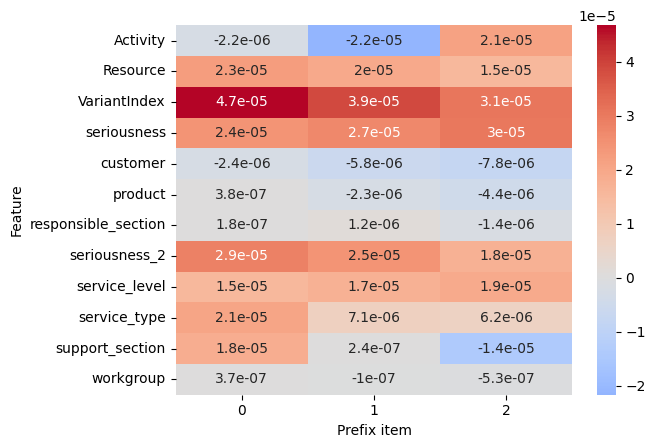

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               30143.000185   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3463669.8020983846]   
                event_elapsed_time    [2032516.210807281]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 4         Value 4  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                          Value 17        Value 17  
                product                            Value 1         Value 1  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 1         Value 1  
                service_level                      Value 2         Value 2  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time               295.049276    12487.051993  
                event_elapsed_time              294.936142    12192.018077  
                day_in_week                            1.0             1.0  
                seconds_in_day                30437.999734    42629.999998  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

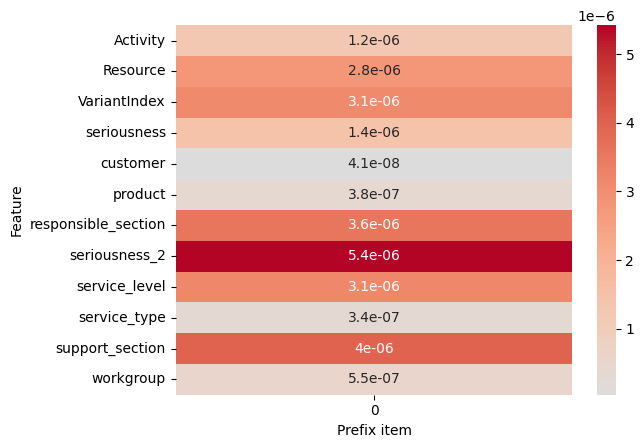

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           3.0   
                seconds_in_day               36873.000075   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time     [831946.3236204574]   
                event_elapsed_time   [391307.31466814806]   

                                               Timestep 2  
Prefix          Activity                              NaN  
                Resource                              NaN  
                VariantIndex                          NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time    [2610749.1320751105]  
                event_elapsed_time    [1409501.983920794]

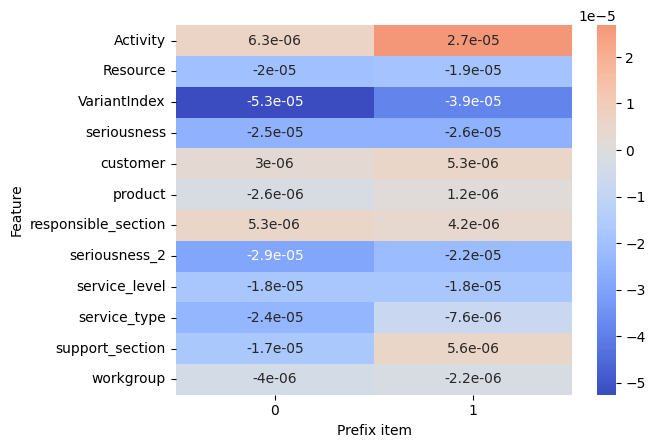

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           3.0   
                seconds_in_day               36873.000075   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1652613.7154442125]   
                event_elapsed_time     [712833.693660272]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 4  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                          Value 17  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 2  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time              2469.047008  
                event_elapsed_time             2468.961397  
                day_in_week                            3.0  
                seconds_in_day                39342.000038  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [3272122.3127895608]  
                event_elapsed_time    [1853409.8559375012]

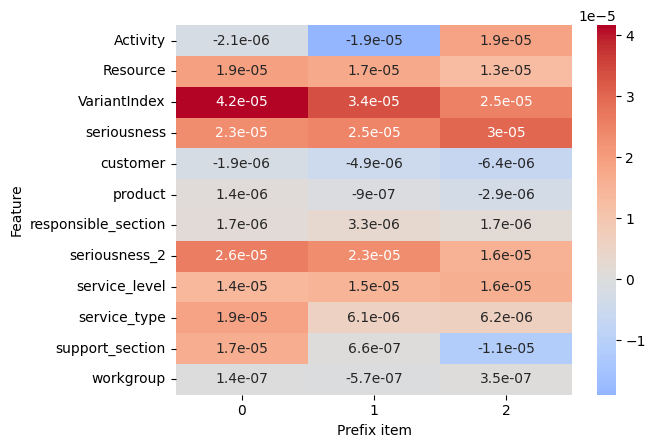

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           3.0   
                seconds_in_day               36873.000075   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3464082.8702423223]   
                event_elapsed_time   [2030740.3853315357]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 4         Value 4  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                          Value 17        Value 17  
                product                            Value 1         Value 1  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 1         Value 1  
                service_level                      Value 2         Value 2  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time              2469.047008   102041.989591  
                event_elapsed_time             2468.961397     99572.96644  
                day_in_week                            3.0             4.0  
                seconds_in_day                39342.000038     52514.99964  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

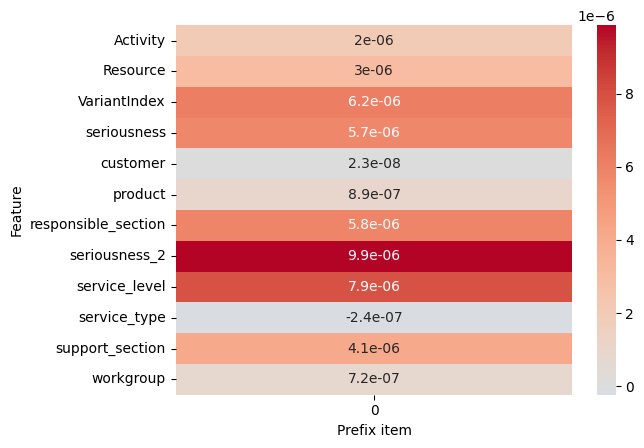

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 1   
                VariantIndex                           1.0   
                seriousness                        Value 1   
                customer                          Value 52   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 2   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                           -0.0   
                seconds_in_day                 29263.00025   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time       [611634.554809799]   
                event_elapsed_time     [324063.8716483826]   

                                               Timestep 2  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                VariantIndex                          NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1250232.9441095088]   
                event_elapsed_time   [457598.50478225166]   

                                               Timestep 3  
Prefix          Activity                              NaN  
                Resource                              NaN  
                VariantIndex                          NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time    [3094550.9081812045]  
                event_elapsed_time   [1743412.6707855116]

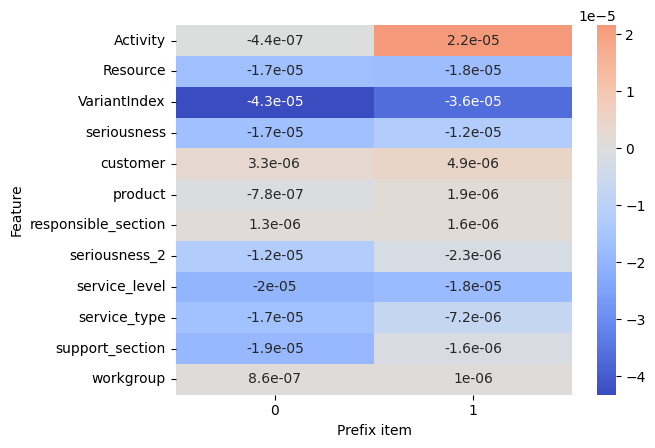

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 52   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day                29263.00025   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1579283.4624431892]   
                event_elapsed_time    [659329.4095409734]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 1  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                          Value 52  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 2  
                service_level                      Value 2  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                14.035539  
                event_elapsed_time               13.994823  
                day_in_week                           -0.0  
                seconds_in_day                29277.000291  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time      [3251009.287657912]  
                event_elapsed_time     [1856260.903716186]

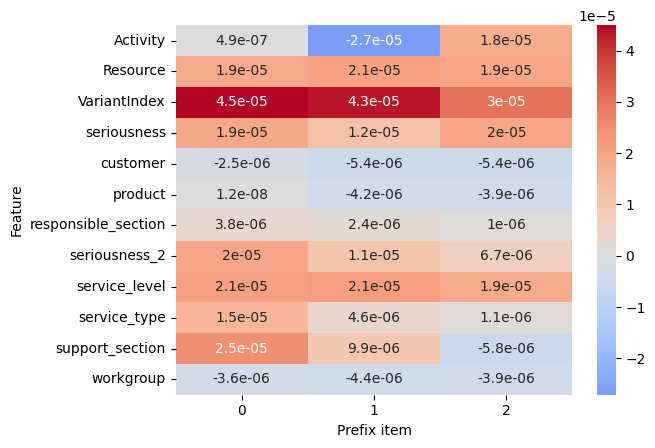

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 52   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day                29263.00025   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3476996.2722178022]   
                event_elapsed_time    [2023309.625595354]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 1         Value 1  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                          Value 52        Value 52  
                product                            Value 1         Value 1  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 2         Value 2  
                service_level                      Value 2         Value 2  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time                14.035539   116852.050544  
                event_elapsed_time               13.994823    116837.96193  
                day_in_week                           -0.0             1.0  
                seconds_in_day                29277.000291    59714.999584  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

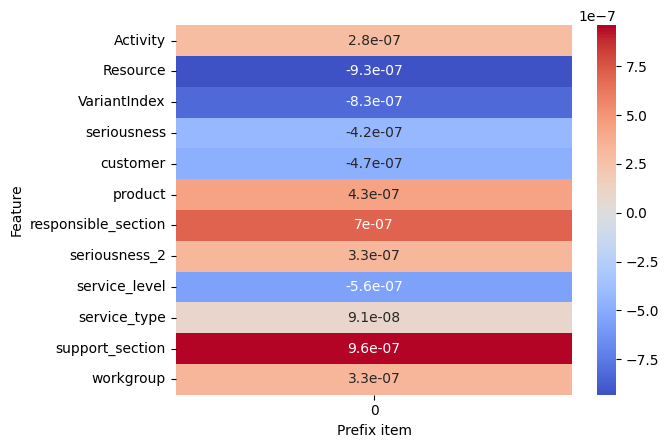

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 1   
                VariantIndex                           2.0   
                seriousness                        Value 1   
                customer                          Value 64   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            1.0   
                seconds_in_day                32412.999791   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time      [363518.0446857583]   
                event_elapsed_time     [271462.4454240416]   

                                              Timestep 2  \
Prefix          Activity                             NaN   
                Resource                             NaN   
                VariantIndex                         NaN   
                seriousness                          NaN   
                customer                             NaN   
                product                              NaN   
                responsible_section                  NaN   
                seriousness_2                        NaN   
                service_level                        NaN   
                service_type                         NaN   
                support_section                      NaN   
                workgroup                            NaN   
                case_elapsed_time                    NaN   
                event_elapsed_time                   NaN   
                day_in_week                          NaN   
                seconds_in_day                       NaN   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [524780.2400772077]   
                event_elapsed_time   [225112.5622887276]   

                                               Timestep 3           Timestep 4  
Prefix          Activity                              NaN                  NaN  
                Resource                              NaN                  NaN  
                VariantIndex                          NaN                  NaN  
                seriousness                           NaN                  NaN  
                customer                              NaN                  NaN  
                product                               NaN                  NaN  
                responsible_section                   NaN                  NaN  
                seriousness_2                         NaN                  NaN  
                service_level                         NaN                  NaN  
                service_type                          NaN                  NaN  
                support_section                       NaN                  NaN  
                workgroup                             NaN                  NaN  
                case_elapsed_time                     NaN                  NaN  
                event_elapsed_time                    NaN                  NaN  
                day_in_week                           NaN                  NaN  
                seconds_in_day                        NaN                  NaN  
Mean Prediction Activity                   Resolve ticket               Closed  
                Resource  

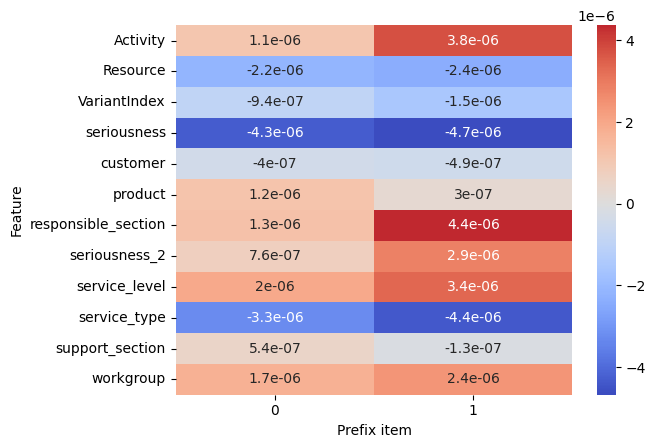

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 1   
                VariantIndex                         2.0   
                seriousness                      Value 1   
                customer                        Value 64   
                product                          Value 1   
                responsible_section              Value 1   
                seriousness_2                    Value 1   
                service_level                    Value 2   
                service_type                     Value 1   
                support_section                  Value 1   
                workgroup                        Value 1   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          1.0   
                seconds_in_day              32412.999791   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [987183.5213968697]   
                event_elapsed_time   [407488.7517272475]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 2  
                VariantIndex                           2.0  
                seriousness                        Value 1  
                customer                          Value 64  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 2  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time             546120.01169  
                event_elapsed_time           546120.028847  
                day_in_week                           -0.0  
                seconds_in_day                60132.999923  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time       [2864848.14781762]  
                event_elapsed_time    [1622065.4563207296]

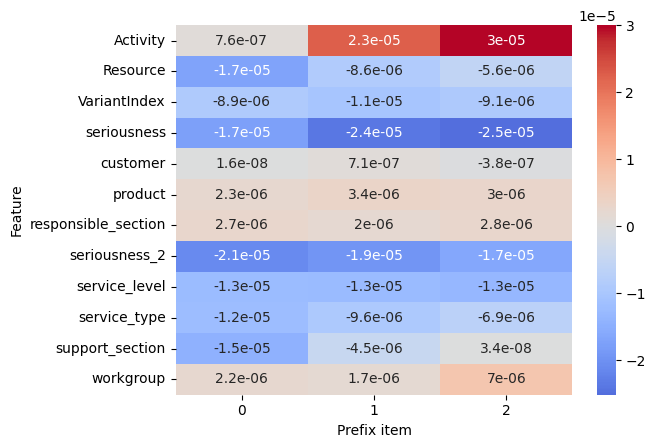

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                         Value 64   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               32412.999791   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time     [2543646.506091138]   
                event_elapsed_time   [1382142.0299217345]   

                                                Timestep 2     Timestep 3  
Prefix          Activity             Take in charge ticket           Wait  
                Resource                           Value 2        Value 2  
                VariantIndex                           2.0            2.0  
                seriousness                        Value 1        Value 1  
                customer                          Value 64       Value 64  
                product                            Value 1        Value 1  
                responsible_section                Value 1        Value 1  
                seriousness_2                      Value 1        Value 1  
                service_level                      Value 2        Value 2  
                service_type                       Value 1        Value 1  
                support_section                    Value 1        Value 1  
                workgroup                          Value 1        Value 1  
                case_elapsed_time             546120.01169  864067.976161  
                event_elapsed_time           546120.028847  317947.963344  
                day_in_week                           -0.0            4.0  
                seconds_in_day                60132.999923   32480.999987  
Mean Prediction Activity                               NaN            NaN  
                Resource                               NaN            NaN  
                case_elapsed_time                      NaN            NaN  
                event_elapsed_time                     NaN            NaN

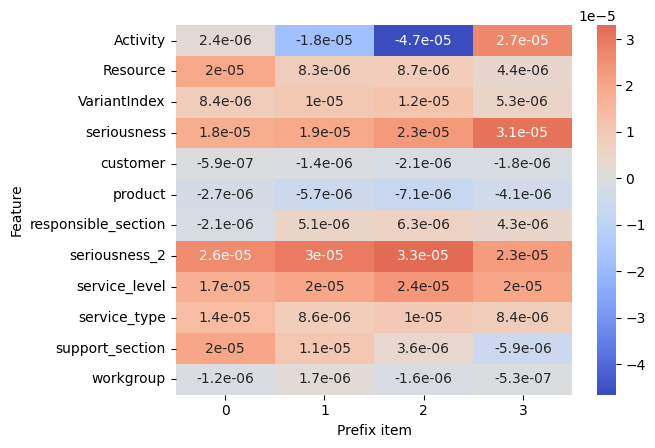

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                         Value 64   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               32412.999791   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3459391.6313217315]   
                event_elapsed_time   [1994695.5219119226]   

                                                Timestep 2     Timestep 3  \
Prefix          Activity             Take in charge ticket           Wait   
                Resource                           Value 2        Value 2   
                VariantIndex                           2.0            2.0   
                seriousness                        Value 1        Value 1   
                customer                          Value 64       Value 64   
                product                            Value 1        Value 1   
                responsible_section                Value 1        Value 1   
                seriousness_2                      Value 1        Value 1   
                service_level                      Value 2        Value 2   
                service_type                       Value 1        Value 1   
                support_section                    Value 1        Value 1   
                workgroup                          Value 1        Value 1   
                case_elapsed_time             546120.01169  864067.976161   
                event_elapsed_time           546120.028847  317947.963344   
                day_in_week                           -0.0            4.0   
                seconds_in_day                60132.999923   32480.999987   
Mean Prediction Activity                               NaN            NaN   
                Resource                               NaN            NaN   
                case_elapsed_time                      NaN            NaN   
                event_elapsed_time                     NaN            NaN   

                                         Timestep 4  
Prefix          Activity             Resolve ticket  
                Resource                    Value 2  
                VariantIndex                    2.0  
                seriousness                 Value 1  
                customer                   Value 64  
                product                     Value 1  
                responsible_section         Value 1  
                seriousness_2               Value 1  
                service_level               Value 2  
                service_type                Value 1  
                support_section             Value 1  
                workgroup                   Value 1  
                case_elapsed_time     1494242.99706  
                event_elapsed_time    630175.000433  
                day_in_week                     4.0  
                seconds_in_day         57856.000731  
Mean Prediction Activity                        NaN  
                Resource                        NaN  
                case_elapsed_time               NaN  
                event_elapsed_time              NaN

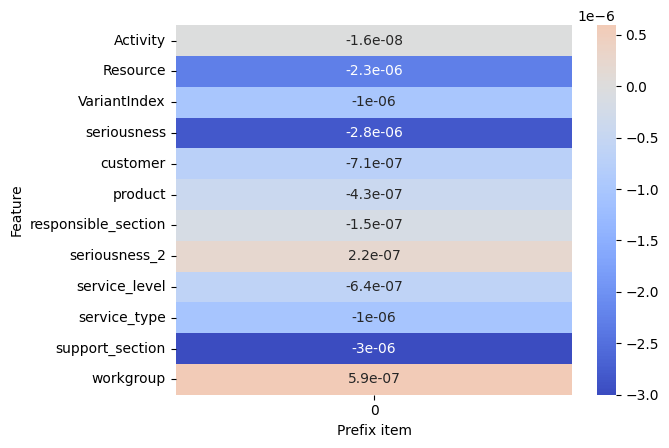

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 1   
                VariantIndex                           2.0   
                seriousness                        Value 1   
                customer                         Value 104   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 2   
                service_level                      Value 3   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            3.0   
                seconds_in_day                44681.000037   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time      [364658.5145612204]   
                event_elapsed_time     [270267.8460882389]   

                                               Timestep 2  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                VariantIndex                          NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time      [526299.968248527]   
                event_elapsed_time   [225088.15263308818]   

                                               Timestep 3  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                VariantIndex                          NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1463121.5831499365]   
                event_elapsed_time    [713109.4306570895]   

                                               Timestep 4  
Prefix          Activity                              NaN  
                Resource                              NaN  
 

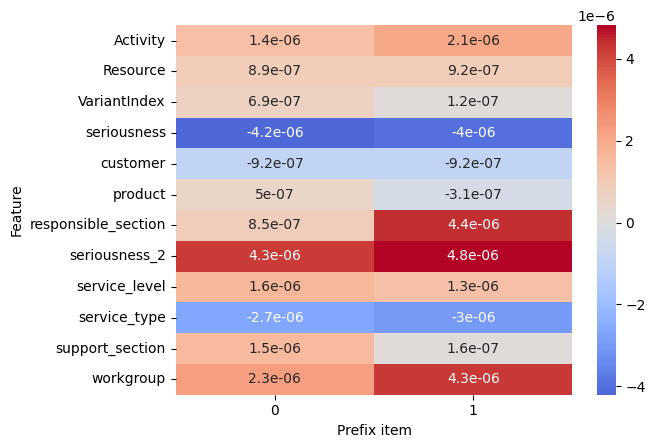

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 1   
                VariantIndex                         2.0   
                seriousness                      Value 1   
                customer                       Value 104   
                product                          Value 1   
                responsible_section              Value 1   
                seriousness_2                    Value 2   
                service_level                    Value 3   
                service_type                     Value 1   
                support_section                  Value 1   
                workgroup                        Value 1   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          3.0   
                seconds_in_day              44681.000037   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [683766.1813216785]   
                event_elapsed_time   [306422.2305665511]   

                                                Timestep 2  \
Prefix          Activity             Take in charge ticket   
                Resource                           Value 1   
                VariantIndex                           2.0   
                seriousness                        Value 1   
                customer                         Value 104   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 2   
                service_level                      Value 3   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                24.080494   
                event_elapsed_time               23.942909   
                day_in_week                            3.0   
                seconds_in_day                44705.000107   
Mean Prediction Activity                    Resolve ticket   
                Resource                           Value 5   
                case_elapsed_time     [2183240.6305232593]   
                event_elapsed_time    [1116509.6057940433]   

                                               Timestep 3  
Prefix          Activity                              NaN  
                Resource                              NaN  
                VariantIndex                          NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time      [3191651.07687552]  
                event_elapsed_time   [1713669.2751091013]

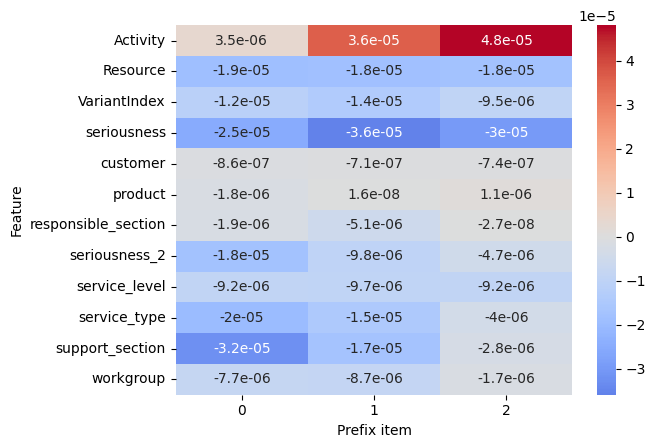

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                        Value 104   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           3.0   
                seconds_in_day               44681.000037   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1770688.9442651032]   
                event_elapsed_time    [799166.4430511144]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket            Wait  
                Resource                           Value 1         Value 1  
                VariantIndex                           2.0             2.0  
                seriousness                        Value 1         Value 1  
                customer                         Value 104       Value 104  
                product                            Value 1         Value 1  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 2         Value 2  
                service_level                      Value 3         Value 3  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time                24.080494  1299691.009689  
                event_elapsed_time               23.942909  1299667.007839  
                day_in_week                            3.0             4.0  
                seconds_in_day                44705.000107    48371.999837  
Mean Prediction Activity                            Closed             NaN  
                Resource                           Value 5             NaN  
                case_elapsed_time      [3274905.010285909]             NaN  
                event_elapsed_time    [1834214.8396379214]             NaN

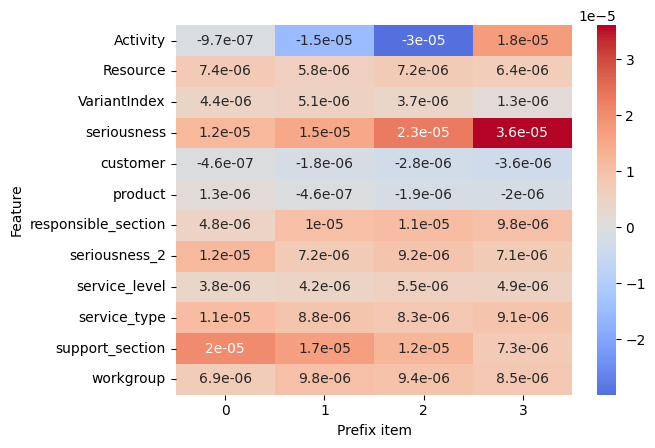

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                        Value 104   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           3.0   
                seconds_in_day               44681.000037   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time      [3484605.93802486]   
                event_elapsed_time   [1994441.2930456402]   

                                                Timestep 2      Timestep 3  \
Prefix          Activity             Take in charge ticket            Wait   
                Resource                           Value 1         Value 1   
                VariantIndex                           2.0             2.0   
                seriousness                        Value 1         Value 1   
                customer                         Value 104       Value 104   
                product                            Value 1         Value 1   
                responsible_section                Value 1         Value 1   
                seriousness_2                      Value 2         Value 2   
                service_level                      Value 3         Value 3   
                service_type                       Value 1         Value 1   
                support_section                    Value 1         Value 1   
                workgroup                          Value 1         Value 1   
                case_elapsed_time                24.080494  1299691.009689   
                event_elapsed_time               23.942909  1299667.007839   
                day_in_week                            3.0             4.0   
                seconds_in_day                44705.000107    48371.999837   
Mean Prediction Activity                               NaN             NaN   
                Resource                               NaN             NaN   
                case_elapsed_time                      NaN             NaN   
                event_elapsed_time                     NaN             NaN   

                                         Timestep 4  
Prefix          Activity             Resolve ticket  
                Resource                    Value 1  
                VariantIndex                    2.0  
                seriousness                 Value 1  
                customer                  Value 104  
                product                     Value 1  
                responsible_section         Value 1  
                seriousness_2               Value 2  
                service_level               Value 3  
                service_type                Value 1  
                support_section             Value 1  
                workgroup                   Value 1  
                case_elapsed_time    1739915.000043  
                event_elapsed_time    440223.988234  
                day_in_week                     2.0  
                seconds_in_day         56595.999698  
Mean Prediction Activity                        NaN  
                Resource                        NaN  
                case_elapsed_time               NaN  
                event_elapsed_time            

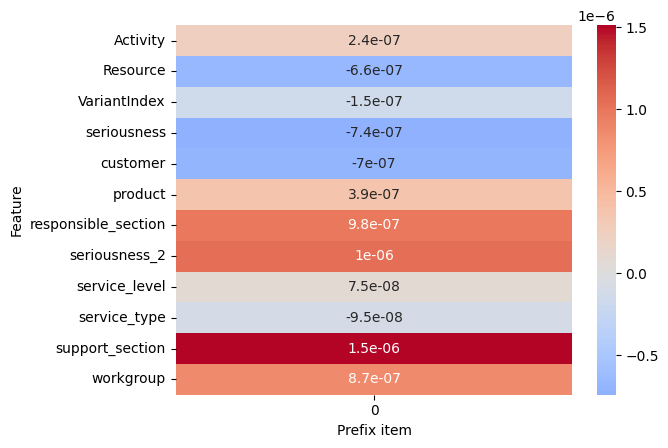

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 8   
                VariantIndex                          17.0   
                seriousness                        Value 1   
                customer                         Value 231   
                product                           Value 12   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            1.0   
                seconds_in_day                 32104.99977   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [314817.28601563396]   
                event_elapsed_time    [291750.73796054325]   

                                                Timestep 2  \
Prefix          Activity                               NaN   
                Resource                               NaN   
                VariantIndex                           NaN   
                seriousness                            NaN   
                customer                               NaN   
                product                                NaN   
                responsible_section                    NaN   
                seriousness_2                          NaN   
                service_level                          NaN   
                service_type                           NaN   
                support_section                        NaN   
                workgroup                              NaN   
                case_elapsed_time                      NaN   
                event_elapsed_time                     NaN   
                day_in_week                            NaN   
                seconds_in_day                         NaN   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [407173.54102604557]   
                event_elapsed_time    [215837.12342551607]   

                                               Timestep 3  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                VariantIndex                          NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time     [806855.6494868039]   
                event_elapsed_time   [280048.61087914056]   

                                              Timestep 4            Timestep 5  
Prefix          Activity                             NaN                   NaN 

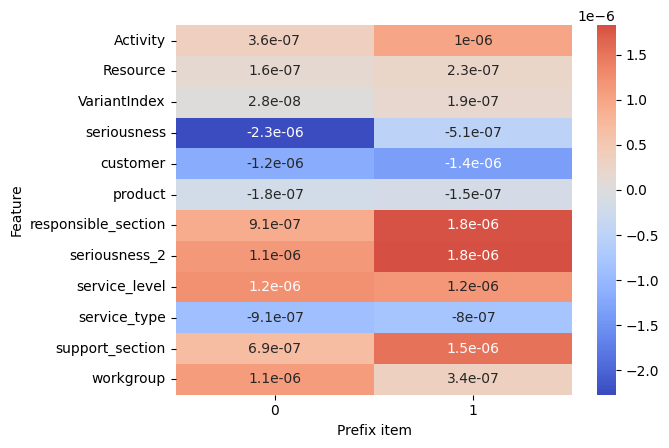

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 8   
                VariantIndex                          17.0   
                seriousness                        Value 1   
                customer                         Value 231   
                product                           Value 12   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            1.0   
                seconds_in_day                 32104.99977   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time      [315095.3597661494]   
                event_elapsed_time     [294830.0390474339]   

                                                Timestep 2  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 8   
                VariantIndex                          17.0   
                seriousness                        Value 1   
                customer                         Value 231   
                product                           Value 12   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 15.99553   
                event_elapsed_time               16.021285   
                day_in_week                            1.0   
                seconds_in_day                32120.999816   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [411212.22537879646]   
                event_elapsed_time    [218950.36775053153]   

                                              Timestep 3  \
Prefix          Activity                             NaN   
                Resource                             NaN   
                VariantIndex                         NaN   
                seriousness                          NaN   
                customer                             NaN   
                product                              NaN   
                responsible_section                  NaN   
                seriousness_2                        NaN   
                service_level                        NaN   
                service_type                         NaN   
                support_section                      NaN   
                workgroup                            NaN   
                case_elapsed_time                    NaN   
                event_elapsed_time                   NaN   
                day_in_week                          NaN   
                seconds_in_day                       NaN   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [806701.8514278734]   
                event_elapsed_time    [281500.432718238]   

                                               Timestep 4  \
Prefix          Activity                              NaN   
                Resource                              NaN  

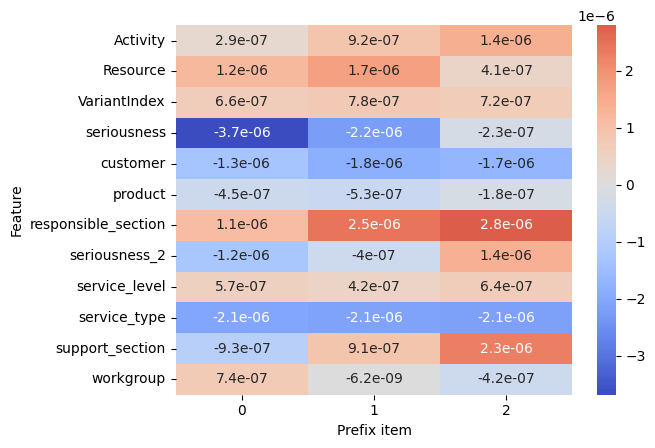

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 8   
                VariantIndex                          17.0   
                seriousness                        Value 1   
                customer                         Value 231   
                product                           Value 12   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            1.0   
                seconds_in_day                 32104.99977   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [520162.99082415504]   
                event_elapsed_time     [219734.7927596838]   

                                               Timestep 2  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                VariantIndex                         17.0   
                seriousness                       Value 1   
                customer                        Value 231   
                product                          Value 12   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                15.99553   
                event_elapsed_time              16.021285   
                day_in_week                           1.0   
                seconds_in_day               32120.999816   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time     [658965.5552597354]   
                event_elapsed_time   [255732.86332999566]   

                                                Timestep 3  \
Prefix          Activity             Take in charge ticket   
                Resource                          Value 13   
                VariantIndex                          17.0   
                seriousness                        Value 1   
                customer                         Value 231   
                product                           Value 12   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time            520162.990824   
                event_elapsed_time           520147.003848   
                day_in_week                           -0.0   
                seconds_in_day                33868.000084   
Mean Prediction Activity                    Resolve ticket   
                Resource                           Value 2   
                case_elapsed_time     [1792810.6298644813]   
                event_elapsed_time     [840873.7017957178]   

                                               Timestep 4  
Prefix          Activity                              NaN  
                Resource                

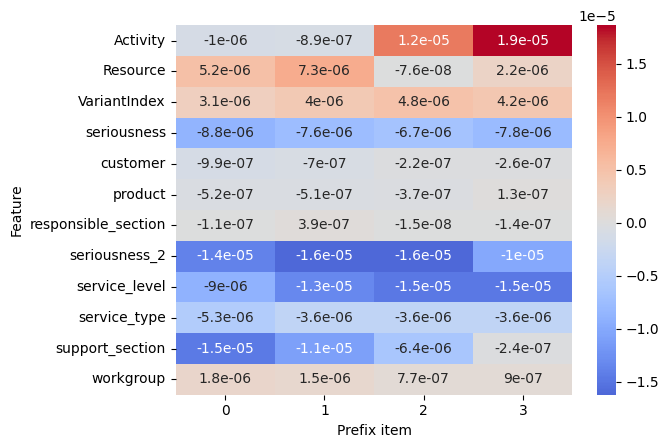

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 8   
                VariantIndex                          17.0   
                seriousness                        Value 1   
                customer                         Value 231   
                product                           Value 12   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 2   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            1.0   
                seconds_in_day                 32104.99977   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [2521179.0045456346]   
                event_elapsed_time      [232254.228801421]   

                                               Timestep 2  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                VariantIndex                         17.0   
                seriousness                       Value 1   
                customer                        Value 231   
                product                          Value 12   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                15.99553   
                event_elapsed_time              16.021285   
                day_in_week                           1.0   
                seconds_in_day               32120.999816   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [2521179.0045456346]   
                event_elapsed_time   [319006.74367134203]   

                                                Timestep 3      Timestep 4  
Prefix          Activity             Take in charge ticket            Wait  
                Resource                          Value 13        Value 13  
                VariantIndex                          17.0            17.0  
                seriousness                        Value 1         Value 1  
                customer                         Value 231       Value 231  
                product                           Value 12        Value 12  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 1         Value 1  
                service_level                      Value 2         Value 2  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time            520162.990824  2521179.004546  
                event_elapsed_time           520147.003848  2001015.964708  
                day_in_week                           -0.0             2.0  
                seconds_in_day                33868.000084    47684.000022  
Mean Prediction Activity                            Closed             NaN  
                Resource                           Value 5             NaN  


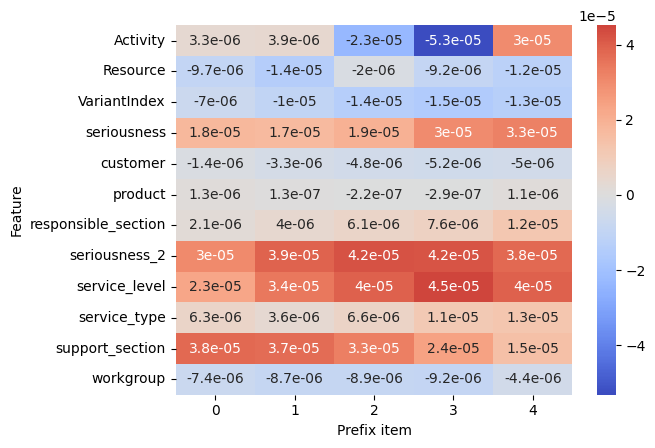

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                VariantIndex                         17.0   
                seriousness                       Value 1   
                customer                        Value 231   
                product                          Value 12   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day                32104.99977   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [3198709.9851573277]   
                event_elapsed_time    [807039.3169180709]   

                                               Timestep 2  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                VariantIndex                         17.0   
                seriousness                       Value 1   
                customer                        Value 231   
                product                          Value 12   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                15.99553   
                event_elapsed_time              16.021285   
                day_in_week                           1.0   
                seconds_in_day               32120.999816   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3289772.0334830717]   
                event_elapsed_time   [1794763.7699696657]   

                                                Timestep 3      Timestep 4  \
Prefix          Activity             Take in charge ticket            Wait   
                Resource                          Value 13        Value 13   
                VariantIndex                          17.0            17.0   
                seriousness                        Value 1         Value 1   
                customer                         Value 231       Value 231   
                product                           Value 12        Value 12   
                responsible_section                Value 1         Value 1   
                seriousness_2                      Value 1         Value 1   
                service_level                      Value 2         Value 2   
                service_type                       Value 1         Value 1   
                support_section                    Value 1         Value 1   
                workgroup                          Value 1         Value 1   
                case_elapsed_time            520162.990824  2521179.004546   
                event_elapsed_time           520147.003848  2001015.964708   
                day_in_week                           -0.0             2.0   
                seconds_in_day                33868.000084    47684.000022   
Mean Prediction Activity                               NaN             NaN   
                Resource                               NaN             NaN   
 

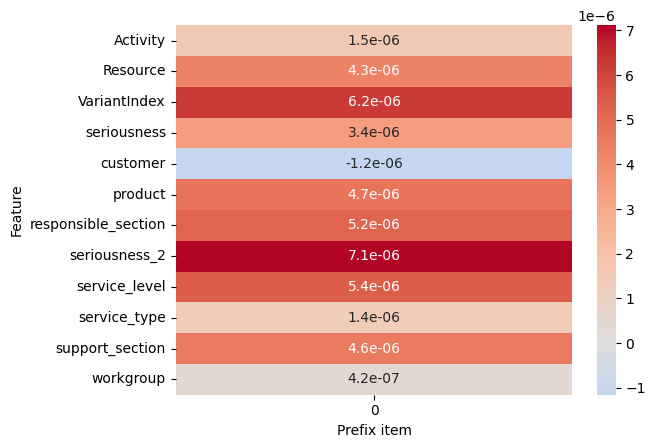

Timestep 1            Timestep 2
Prefix          Activity              Assign seriousness                   NaN
                Resource                         Value 1                   NaN
                VariantIndex                         1.0                   NaN
                seriousness                      Value 1                   NaN
                customer                       Value 113                   NaN
                product                         Value 11                   NaN
                responsible_section              Value 1                   NaN
                seriousness_2                    Value 1                   NaN
                service_level                    Value 2                   NaN
                service_type                     Value 1                   NaN
                support_section                  Value 1                   NaN
                workgroup                        Value 1                   NaN
                case_elapsed_time               0.070602                   NaN
                event_elapsed_time           963303.3125                   NaN
                day_in_week                          3.0                   NaN
                seconds_in_day              34325.999669                   NaN
Mean Prediction Activity                  Resolve ticket                Closed
                Resource                         Value 2               Value 5
                case_elapsed_time    [727388.7253100325]  [2386462.5623746496]
                event_elapsed_time   [359546.7603168405]  [1250237.2709452687]

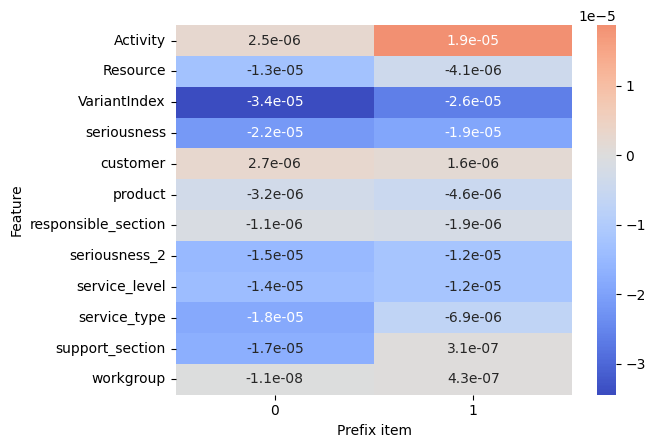

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 1   
                VariantIndex                         1.0   
                seriousness                      Value 1   
                customer                       Value 113   
                product                         Value 11   
                responsible_section              Value 1   
                seriousness_2                    Value 1   
                service_level                    Value 2   
                service_type                     Value 1   
                support_section                  Value 1   
                workgroup                        Value 1   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          3.0   
                seconds_in_day              34325.999669   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [1524688.673382045]   
                event_elapsed_time    [649778.970576209]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 2  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                         Value 113  
                product                           Value 11  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 2  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time             87021.964581  
                event_elapsed_time             87021.98207  
                day_in_week                            4.0  
                seconds_in_day                34947.999728  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [3230799.5734673645]  
                event_elapsed_time     [1860872.486393876]

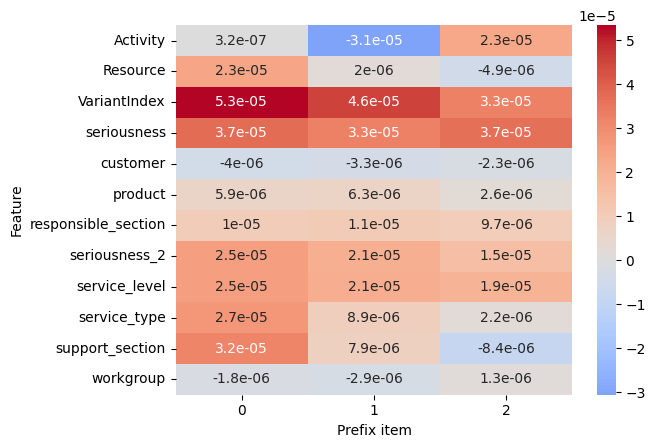

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                        Value 113   
                product                          Value 11   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           3.0   
                seconds_in_day               34325.999669   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3452003.1995205902]   
                event_elapsed_time   [2037549.8502477626]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 2         Value 2  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                         Value 113       Value 113  
                product                           Value 11        Value 11  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 1         Value 1  
                service_level                      Value 2         Value 2  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time             87021.964581    97096.074315  
                event_elapsed_time             87021.98207    10073.996863  
                day_in_week                            4.0             4.0  
                seconds_in_day                34947.999728    45021.999936  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

In [ ]:
from classes.event import Event, HelpdeskEvent
from classes.sequence import Sequence
from classes.suffix_samples import SuffixSamples
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def fetch_attributions(row):
    prefix_length = row.loc["prefix_len"]
    case_name = row.loc["case_name"]
    attribution_tensor = row.loc["attributions_predicted_activity"].squeeze(0)
    attribution_list = []
    for time_step in attribution_tensor[-prefix_length:]:

        attr = unpack_attribution(time_step[0])
        attribution_list.append(attr)
    

    return attribution_list, prefix_length, case_name


def unpack_attribution(sample_tensor):
    start_index = 0
    attribution_dict = {}

    for idx, encoded_attribute in enumerate(new_eval.prefix_cat_attributes):
        embedding_dim = new_eval.model.encoder.embeddings[idx].embedding_dim
        attribution_dict[encoded_attribute] = sample_tensor[start_index:start_index+embedding_dim].mean()
        start_index += embedding_dim

    return attribution_dict


def visualize_attribution(attribution_list, prefix_len, case_name, inference_results):
    # --- Attribution heatmap ---
    df_attr = pd.DataFrame(
        [{k: v.detach().item() for k, v in d.items()} for d in attribution_list]
    )
    sns.heatmap(df_attr.T, center=0, cmap="coolwarm", annot=True)
    plt.xlabel("Prefix item")
    plt.ylabel("Feature")
    plt.show()

    # --- Fetch corresponding inference row ---
    row = inference_results[
        (inference_results["prefix_len"] == prefix_len) &
        (inference_results["case_name"] == case_name)
    ]

    if row.empty:
        print("No prefix or mean prediction found for this row.")
        return

    prefix = row.iloc[0]["prefix"]
    mean_prediction = row.iloc[0]["mean_prediction"]

    # --- Prefix: list of dicts (one dict per timestep) ---
    df_prefix = pd.DataFrame(prefix).T
    df_prefix.columns = [f"Timestep {i+1}" for i in range(df_prefix.shape[1])]

    # --- Mean prediction: list of dicts (one dict per timestep) ---
    # unwrap scalar lists if needed
    cleaned_mean_pred = []
    for step in mean_prediction:
        cleaned_step = {
            k: (v[0] if isinstance(v, list) and len(v) == 1 else v)
            for k, v in step.items()
        }
        cleaned_mean_pred.append(cleaned_step)

    df_mean_pred = pd.DataFrame(cleaned_mean_pred).T
    df_mean_pred.columns = [f"Timestep {i+1}" for i in range(df_mean_pred.shape[1])]

    # --- Combine for display ---
    df_combined = pd.concat(
        [df_prefix, df_mean_pred],
        keys=["Prefix", "Mean Prediction"]
    )

    display(df_combined)



for idx, row in results_df.iterrows():
    attribution_list, prefix_length, case_name = fetch_attributions(row)
    visualize_attribution(attribution_list, prefix_length, case_name, inference_results)